In [66]:
import sys
sys.path.append('/home/rwb/github/skaworkflows')
import os
import logging
import json

from pathlib import Path
import seaborn as sns

logging.basicConfig(level='INFO')
LOGGER = logging.getLogger(__name__)
%pwd 
%cd /home/rwb/Dropbox/University/PhD/experiment_data/chapter3/initial_results
plt_dir = Path("/home/rwb/github/thesis_experiments/chapter3/plots/")

/home/rwb/Dropbox/University/PhD/experiment_data/chapter3/initial_results


In [4]:
import pandas as pd
workflows = ['ICAL','DPrepA', 'DPrepB', 'DPrepC','DPrepD']

# HPSO and their standard durations (from parameteric model) 
low_hpsos = {'hpso01':18000, 'hpso02a':18000, 'hpso02b':18000}
mid_hpsos = {'hpso13': 28800 ,'hpso15':15840 , 'hpso22':28800, 'hpso32':7920}

# Setup multipler for a given observation
compute_unit = 10**15 # Peta flop
data_unit = 10**6 # per million visibilites 
bytes_per_vis = 12 

# Runtime of the parametric model on provisional SDP infrastructure. Taken from parametric model outputs in SKA Workflows code
par_dict = {'hpso32':706,
'hpso22': 62847,
'hpso02b':26732,
'hpso02a':26732,
'hpso13':5655,
'hpso01':32090,
'hpso15':504}

In [46]:
low_path = Path("low_maximal/prototype")
low_system_config_path = low_path / 'no_data_low_sdp_config_prototype_n896_896channels.json'
df = pd.DataFrame()

with open(low_system_config_path) as fp: 
    low_system_config = json.load(fp)
    
flops,compute_bandwidth,memory = low_system_config['cluster']['system']['resources']['GenericSDP_m0'].values()
print(flops/10**12, compute_bandwidth/10**9)

print(os.getcwd()) 
# structure the data according to | product | workflow | time | type (long-form data) rather than wide form
for hpso in low_hpsos:
    for wf in workflows: 
        hpso_df = pd.DataFrame()
        workflow_data_path = low_path / f"workflows/workflow_stats/{hpso}_time-{low_hpsos[hpso]}_channels-896_tel-512_no_data-standard.json_{wf}_data"
        with open(workflow_data_path) as fp: 
            workflow_data = json.load(fp)
        
        for product in workflow_data:
            columns = {'HPSO': hpso, 'Product': product, 'Workflow': wf, 'Transfer Data Cost':[],  'Time (s)': [], 'Parametric Runtime':[], 'Type': []}
            curr_product_dict = workflow_data[product]
            if 'total_compute' in workflow_data[product]:
                compute = curr_product_dict['fraction_compute_cost']  * low_hpsos[hpso] * compute_unit
                columns['Time (s)'].append(compute / flops)
                columns['Type'].append('compute')
                data = curr_product_dict['fraction_data_cost'] * low_hpsos[hpso] * data_unit * bytes_per_vis
                columns['Time (s)'].append(data / compute_bandwidth)
                columns['Transfer Data Cost'] = curr_product_dict['fraction_data_cost'] * low_hpsos[hpso] * data_unit * bytes_per_vis
                columns['Parametric Runtime'] = par_dict[hpso] 
                columns['Type'].append('data')
            tmp_df = pd.DataFrame(columns,)
            hpso_df = hpso_df.append(tmp_df, ignore_index=True)
        df = df.append(hpso_df, ignore_index=True)

10.726 7.5304827
/home/rwb/Dropbox/University/PhD/experiment_data/chapter3/initial_results


In [47]:
mid_path = Path("mid_maximal/prototype")

mid_system_config_path = mid_path / 'no_data_mid_sdp_config_prototype_n786_786channels.json'

with open(mid_system_config_path) as fp: 
    mid_system_config = json.load(fp)

flops,compute_bandwidth,memory = mid_system_config['cluster']['system']['resources']['GenericSDP_m0'].values()
print(flops/10**12, compute_bandwidth/10**9)

for hpso in mid_hpsos:
    for wf in workflows: 
        hpso_df = pd.DataFrame()
        workflow_data_path = mid_path / f"workflows/workflow_stats/{hpso}_time-{mid_hpsos[hpso]}_channels-786_tel-197_no_data-standard.json_{wf}_data"
        
        try:
            with open(workflow_data_path) as fp: 
                workflow_data = json.load(fp)
        except:
            print(f"{workflow_data_path.name} represents a workflow that doesn't exist")
            continue 

        for product in workflow_data:
            columns = {'HPSO': hpso, 'Product': product, 'Workflow': wf, 'Transfer Data Cost':[],  'Time (s)': [], 'Type': []}
            curr_product_dict = workflow_data[product]
            if 'total_compute' in workflow_data[product]:
                compute = curr_product_dict['fraction_compute_cost']  * mid_hpsos[hpso] * compute_unit
                columns['Time (s)'].append(compute / flops)
                columns['Type'].append('compute')
                data = curr_product_dict['fraction_data_cost'] * mid_hpsos[hpso] * data_unit * bytes_per_vis
                columns['Time (s)'].append(data / compute_bandwidth)
                columns['Transfer Data Cost'] = curr_product_dict['fraction_data_cost'] * mid_hpsos[hpso] * data_unit * bytes_per_vis 
                columns['Parametric Runtime'] = par_dict[hpso] 
                columns['Type'].append('data')
            tmp_df = pd.DataFrame(columns,)
            hpso_df = hpso_df.append(tmp_df, ignore_index=True)
        df = df.append(hpso_df, ignore_index=True)

7.502 14.100652035
hpso13_time-28800_channels-786_tel-197_no_data-standard.json_DPrepD_data represents a workflow that doesn't exist
hpso15_time-15840_channels-786_tel-197_no_data-standard.json_DPrepD_data represents a workflow that doesn't exist
hpso22_time-28800_channels-786_tel-197_no_data-standard.json_DPrepC_data represents a workflow that doesn't exist
hpso22_time-28800_channels-786_tel-197_no_data-standard.json_DPrepD_data represents a workflow that doesn't exist
hpso32_time-7920_channels-786_tel-197_no_data-standard.json_DPrepA_data represents a workflow that doesn't exist
hpso32_time-7920_channels-786_tel-197_no_data-standard.json_DPrepC_data represents a workflow that doesn't exist
hpso32_time-7920_channels-786_tel-197_no_data-standard.json_DPrepD_data represents a workflow that doesn't exist


In [7]:
# df[df["HPSO"] == 'hpso02b']
df = df.loc[(df!=0).all(1)]
products = set(df["Product"])
products

{'Correct',
 'Degrid',
 'FFT',
 'Flag',
 'Grid',
 'IFFT',
 'Identify Component',
 'Predict',
 'Solve',
 'Source Find',
 'Subtract',
 'Subtract Image Component',
 'UpdateLSM'}

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm, LogNorm, TwoSlopeNorm, Normalize
from matplotlib import cm
df_comp = df[df['Type']== 'compute'].reset_index(drop=True)
df_data = df[df['Type']== 'data'].reset_index(drop=True)

df_comp.loc[:, "ratio"] = ((np.array(df_data['Time (s)']) / np.array(df_comp['Time (s)'])))
df_comp = df_comp.dropna()
df_comp = df_comp.sort_values(by='HPSO')


plt.ioff()
f, ax = plt.subplots(figsize=(8,5),dpi=300)

colorpalette = 'coolwarm'

x = df_comp['Workflow']
y = df_comp['Product']
arrays = []

hpsos = {**low_hpsos, **mid_hpsos} 

for hpso in hpsos:
    arrays.append(np.array(df_comp[(df_comp['HPSO']==hpso) & (df_comp['ratio'] >= (10**(-5)))]['ratio']))
# y3 = np.vstack(arrays).T
# print(y3)

## TODO make the color-bar plot as well 
y2 = np.array(df_comp[(df_comp['ratio'] > (10**(-5)))]['ratio'])
rest = ax.boxplot(arrays,labels=hpsos.keys())#, mid_hpsos.keys()) #,labels=mid_hpsos) #, 'ICAL') #, y)
ax.set_yscale('log')
# cb = f.colorbar(res)
ax.set_ylabel('Ratio (I/O : FLOPs)') 
# cb.ax.yaxis.set_label_coords(4,0.5)
ax.set_title("Distribution of I/O to FLOPs ratio of SKA Workflow alorithms across HPSOs", pad=25)
# plt.show()
plt.savefig(plt_dir / "RuntimeComparisons_BoxPlotRange.png", facecolor="white", transparent=False, bbox_inches="tight")

/tmp/ipykernel_254610/2868738265.py:8: RuntimeWarning: invalid value encountered in true_divide
  df_comp.loc[:, "ratio"] = ((np.array(df_data['Time (s)']) / np.array(df_comp['Time (s)'])))


In [69]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm, LogNorm, TwoSlopeNorm, Normalize
from matplotlib import cm
df_comp = df[df['Type']== 'compute'].reset_index(drop=True)
df_data = df[df['Type']== 'data'].reset_index(drop=True)

# Four lines below are referring to the 
df_comp['Workflow'] = df_comp['Workflow'].str.replace('ICAL','DICAL')
df_data['Workflow'] = df_data['Workflow'].str.replace('ICAL','DICAL')

df_data = df_data.sort_values(by=['Workflow','Product'], ascending=[True,False])
df_comp = df_comp.sort_values(by=['Workflow','Product'], ascending=[True,False])
df_comp.loc[:, "ratio"] = ((np.array(df_data['Time (s)']) / np.array(df_comp['Time (s)'])))
df_comp = df_comp.dropna()
# df_comp = df_comp.sort_values(by=['HPSO']).sort_values(by=['Product'], ascending=False)


plt.ioff()
f, ax = plt.subplots(figsize=(8,8),dpi=300)

colorpalette = 'coolwarm'

x = df_comp['Workflow']
y = df_comp['Product']
arrays = []

hpsos = {**low_hpsos, **mid_hpsos} 

for hpso in hpsos:
    arrays.append(np.array(df_comp[df_comp['HPSO']==hpso]['ratio']))
norm = LogNorm(vmin=0.001, vmax=1000)
## TODO make the color-bar plot as well 
y2 = np.array(df_comp['ratio'])
# norm = TwoSlopeNorm( vcenter=1, vmin=df_comp['ratio'].min(), vmax=200) # , vmin=df_comp['ratio'].min(), vmax=df_comp['ratio'].max())
res = ax.scatter(x,y, c=df_comp['ratio'], cmap=colorpalette, norm=norm, s=400)
ax.set_ylabel("Algorithm", fontsize=16)
ax.set_xlabel("Ratio (I/O-intensive > 1)", fontsize=16)
cb = f.colorbar(res)
cb.ax.set_ylabel('Ratio (I/O : FLOPs)') 
ax.set_title("Runtime comparison of SKA Workflow algorithms as a ratio of I/O to FLOPs", pad=25)
# plt.show()
plt.savefig(plt_dir / "RuntimeComparisons.png", facecolor="white", transparent=False, bbox_inches="tight")

/tmp/ipykernel_254610/4153952585.py:14: RuntimeWarning: invalid value encountered in true_divide
  df_comp.loc[:, "ratio"] = ((np.array(df_data['Time (s)']) / np.array(df_comp['Time (s)'])))


dict_keys(['hpso01', 'hpso02a', 'hpso02b', 'hpso13', 'hpso15', 'hpso22', 'hpso32'])


<Figure size 432x288 with 0 Axes>

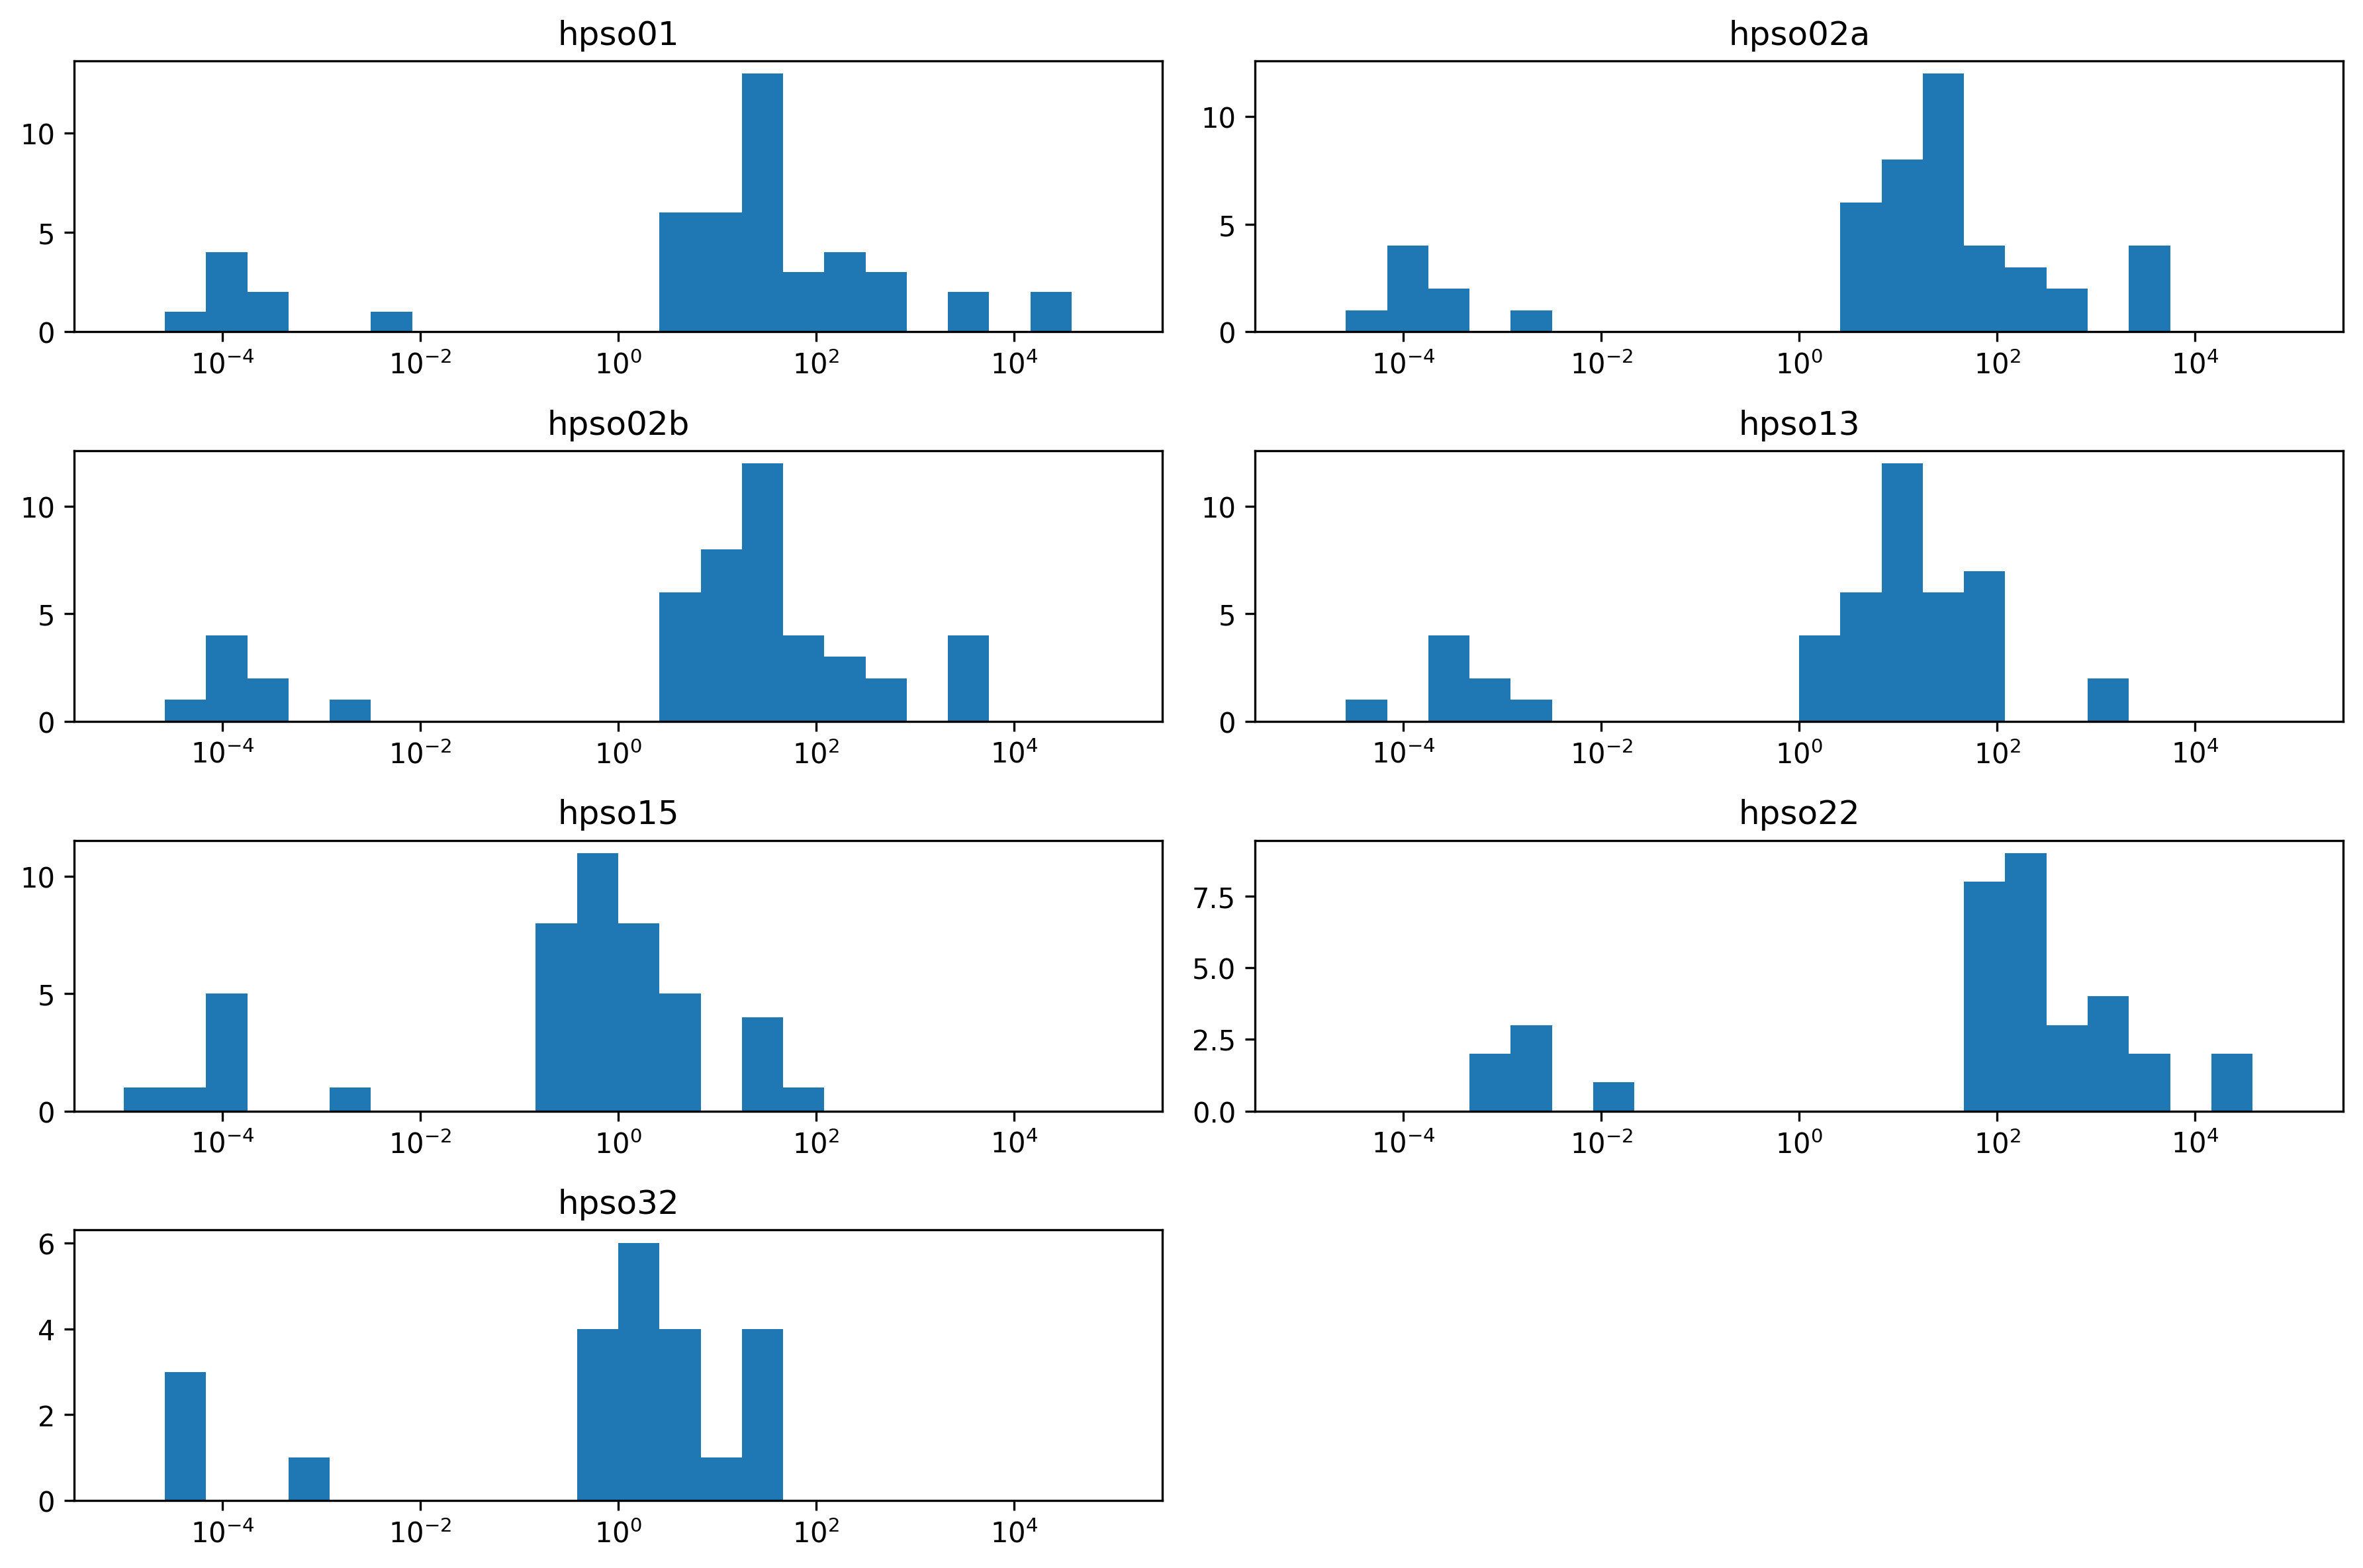

In [10]:
hpsos = {**low_hpsos, **mid_hpsos} 

arrays = []
for hpso in hpsos:
    arrays.append(np.array(df_data[df_data['HPSO']==hpso]['Time (s)']))
print(hpsos.keys())
fig, axes  = plt.subplots(nrows=4, ncols=2, figsize=(12,8),dpi=300)
bins = np.logspace(np.log10(10**(-5)), np.log10(10**5),25)
for x in range(0,4):
    i = 0 
    for y in range(0,2):
        i = x + y
        if x > 0: 
            i += 1*(x)
        if i > (len(hpsos.keys())-1):
            break
        hpso=list(hpsos.keys())[i]
        axes[x][y].hist(arrays[i], label=hpso, bins=bins)
        axes[x][y].set_xscale("log")
        axes[x][y].set_title(hpso)
        axes[x][y].set_title(hpso)
fig.delaxes(axes[x,y])
fig.align_labels()
fig.tight_layout()
plt.show()

### What is the plot below showing? 

We want to cross-compare the range of different I/O-intensive durations to confirm the reasons for the significant increases in workflow schedule length compared to the parametric model.  

In [77]:
fix, axes = plt.subplots(figsize=(8,8),dpi=300)
plt.rcParams.update({'font.size': 14})

df_comp = df_comp.sort_values(by='HPSO')
df_comp_dataintensive = df_comp[df_comp['ratio']>=1]
df_comp_dataintensive['Transfer data time'] = df_comp_dataintensive['Transfer Data Cost'] / compute_bandwidth 
df_comp_dprepb = df_comp_dataintensive[df_comp_dataintensive['Transfer data time'] >=1]

axes.set_ylabel("Transfer data time", fontsize=16)
axes.set_xlabel("HPSO", fontsize=16)
axes.set_title("Distribution of I/O-intensive algorithms estimated transfer time across selected HPSOs", fontsize=16, pad=25)

sns.swarmplot(data=df_comp_dprepb, x='HPSO', y='Transfer data time',ax=axes, log_scale=10,c='b')
# plt.show()
plt.savefig(plt_dir / "Supplementary_reasons_for_variation_plot.png", facecolor="white", transparent=False, bbox_inches="tight")
print((len(df_comp_dataintensive)- len(df_comp_dprepb))/7)

/tmp/ipykernel_254610/2297186868.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comp_dataintensive['Transfer data time'] = df_comp_dataintensive['Transfer Data Cost'] / compute_bandwidth


3.142857142857143


In [ ]:
hpso22_subtract =  6.2667404992709335
hpso32_subtract = 0.12864370894917693